In [ ]:
!pip install tensorflow==2.2

!pip install --upgrade tensorflow-addons
!pip install segmentation_models

! pip install --upgrade wandb
! wandb login ce34dba45046882924ce29d78f403b369bd8a80d

!git clone https://github.com/dragynir/deeplr.git
!git clone https://github.com/ashawkey/volumentations.git


In [ ]:
!cp -r '/content/drive/My Drive/Faults/data/synt/dataset_model_fda512.zip' ./
!unzip -qq /content/dataset_model_fda512.zip

In [ ]:
!rm -rf '/content/content/'

In [1]:
from glob import glob

import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import os
import cv2
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import tensorflow_addons as tfa

SEED = 42 # --------------------------------- SEED

np.random.seed(SEED)
tf.random.set_seed(SEED)


import os
# for segmentation_models
os.environ["SM_FRAMEWORK"] = 'tf.keras'



AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")
print(f"Tensorflow addons ver. {tfa.__version__}")

Tensorflow ver. 2.2.0
Tensorflow addons ver. 0.11.2


In [2]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="faults-segmentation")
WB_CONFIG = wandb.config

wandb: Currently logged in as: dragynir (use `wandb login --relogin` to force relogin)


In [24]:
from scipy import ndimage as ndi

for f in os.listdir(dataset_path):
    pair = parse_image(f)
    lb = pair['label']
    tr = pair['trace']

    # make a little 3D diamond:
    diamond = ndi.generate_binary_structure(rank=3, connectivity=1) # try rank 2
    # dilate 30x with it
    dilated = ndi.binary_dilation(lb.numpy().squeeze(), diamond, iterations=1)

    dilated.flatten().astype('float32').tofile(dataset_path.replace('traces', 'labels') + f, format='%.4f')

# SliceViewer(tr.numpy().squeeze(), dilated, figsize=(12, 12), tr_cmap='gray', lb_cmap='Greens')

In [10]:
from volumentations.volumentations import *

AUGS = Compose([
        # ElasticTransform(deformation_limits=(0.1, 0.25)),
        GaussianNoise(var_limit=(0, 0.03)),
        Rotate((-15,15),(-15,15),(-15,15)),
    ], p=1)

In [11]:

IMG_SIZE = 128

VOLUME_SHAPE = [IMG_SIZE, IMG_SIZE, IMG_SIZE]

dataset_path = '/content/content/dataset/traces/'

def load_numpy(path):
   return np.fromfile(path.numpy(), dtype=np.float32)

def parse_image(img_name: str):

    trace_path = dataset_path + img_name
    label_path = tf.strings.regex_replace(trace_path, "traces", "labels")

    trace = tf.py_function(func=load_numpy, inp=[trace_path], Tout=tf.float32)

    label = tf.py_function(func=load_numpy, inp=[label_path], Tout=tf.float32)

    trace = tf.reshape(trace, VOLUME_SHAPE)

    label = tf.reshape(label, VOLUME_SHAPE)

    return {'trace': trace, 'label': label}



def perform_augs(trace, label):
    trace = trace.numpy()
    label = label.numpy()

        
    data = {'image': trace, 'mask': label}
    aug_data = AUGS(**data)

    trace = aug_data['image']
    label = aug_data['mask']

    # aug = AUGS.to_deterministic()
    # for i in range(trace.shape[0]):
    #     tr, lb = aug(image=trace[i].T[..., None], segmentation_maps=label[i].T.astype(np.int32)[None, ...])

    #     trace[i] = tr.squeeze().T
    #     label[i] = lb.squeeze().T.astype(np.float32)

    return trace, label


def augmentations(trace, label):

    r_axis = tf.random.uniform(shape=[], maxval=2, dtype=tf.int32, seed=SEED)

    do_r = tf.random.uniform(shape=[], maxval=1, dtype=tf.int32, seed=SEED)

    # rewrite tf style
    if do_r == 0:
        # done
        trace = tf.reverse(trace, axis=[r_axis])
        label = tf.reverse(label, axis=[r_axis])
    
    trace, label = tf.py_function(func=perform_augs, inp=[trace, label], Tout=[tf.float32, tf.float32])

    
    return trace, label





def scale_min_max(trace):
    min_v = tf.math.reduce_min(trace)
    max_v = tf.math.reduce_max(trace)
    return (trace - min_v) / (max_v - min_v)

def standardise(trace):
    mean = tf.math.reduce_mean(trace)
    std = tf.math.reduce_std(trace)
    return (trace - mean) / std

@tf.function
def load_image_train(datapoint):

    trace, label = datapoint['trace'], datapoint['label']

    trace, label = augmentations(trace, label)

    # trace = standardise(scale_min_max(trace))
    trace = scale_min_max(trace)

    trace = tf.reshape(trace, VOLUME_SHAPE + [1,])
    label = tf.reshape(label, VOLUME_SHAPE + [1,])

    return trace, label

@tf.function
def load_image_valid(datapoint):

    trace, label = datapoint['trace'], datapoint['label']

    # trace = standardise(scale_min_max(trace))
    trace = scale_min_max(trace)

    trace = tf.reshape(trace, VOLUME_SHAPE + [1,])
    label = tf.reshape(label, VOLUME_SHAPE + [1,])

    return trace, label

In [12]:
from sklearn.model_selection import train_test_split


images = os.listdir(dataset_path)

train_images, valid_images = train_test_split(images, test_size=0.07, random_state=SEED)
valid_images, test_images = train_test_split(valid_images, test_size=0.3, random_state=SEED)


TRAINSET_SIZE = len(train_images)
VALSET_SIZE = len(valid_images)
TESTSET_SIZE = len(test_images)


print(f'Train size: {TRAINSET_SIZE}')
print(f'Valid size: {VALSET_SIZE}')
print(f'Test size: {TESTSET_SIZE}')


train_dataset = tf.data.Dataset.from_tensor_slices(train_images)

val_dataset = tf.data.Dataset.from_tensor_slices(valid_images)

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

Train size: 476
Valid size: 25
Test size: 11


In [13]:
WB_CONFIG.BATCH_SIZE = 4


BUFFER_SIZE = 500

dataset = {"train": train_dataset, "valid": val_dataset, "test": test_dataset}

dataset['train'] = (dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED, reshuffle_each_iteration=True).
                    map(parse_image).
                    map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).
                    repeat().
                    batch(WB_CONFIG.BATCH_SIZE).
                    prefetch(buffer_size=AUTOTUNE))

dataset['valid'] = (dataset['valid'].map(parse_image).
                    map(load_image_valid).
                    batch(WB_CONFIG.BATCH_SIZE).
                    prefetch(buffer_size=AUTOTUNE))


dataset['test'] = (dataset['test'].map(parse_image).
                    map(load_image_valid).
                    batch(WB_CONFIG.BATCH_SIZE).
                    prefetch(buffer_size=AUTOTUNE))


0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


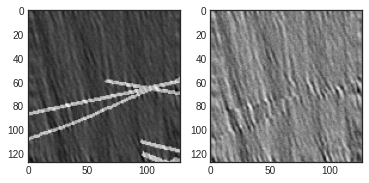

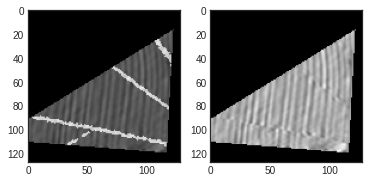

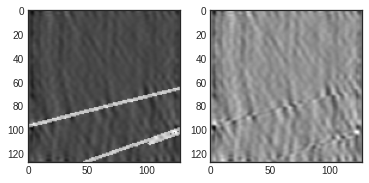

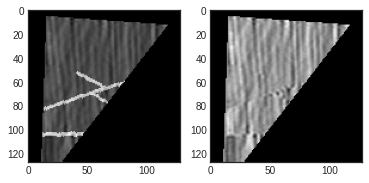

In [14]:
check_label = None

for (traces, labels) in dataset['train'].take(1): # train, pretrain
    for i, tr in enumerate(traces):
        lb = labels[i]

        check_label = lb

        print(tr.numpy().min(), tr.numpy().max())
        # check rotation here
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(tr.numpy()[0].squeeze(), cmap='gray')
        axs[0].imshow(lb.numpy()[0].squeeze(), cmap='gray', alpha=0.5)
        axs[1].imshow(tr.numpy()[0].squeeze(), cmap='gray')

    break

In [15]:
#@title slice viewer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets.widgets import *
from ipywidgets import widgets
from IPython.display import display

plt.style.use('seaborn-white')



class SliceViewer():

    '''
        Arguments: 
            traces_volume - np.array with shape (nx, ny, nz)
            labels_volume - np.array with shape (nx, ny, nz)
            figsize - tuple, plot size

    '''

    def __init__(self, traces_volume, labels_volume,
                 figsize=(7, 7), tr_cmap='gray', lb_cmap='Greens'):

        assert traces_volume.shape == labels_volume.shape, 'Shapes must be equal'

        self.tr_volume = traces_volume
        self.lb_volume = labels_volume
        self.figsize = figsize
        self.tr_cmap = tr_cmap
        self.lb_cmap = lb_cmap

        self.nx, self.ny, self.nz = self.tr_volume.shape

        self.widget = self.__create_widget()


    def __create_widget(self):

        x_slider = IntSlider(min=0, max=self.nx - 1, step=1, value=int(self.nx/2))
        y_slider = IntSlider(min=0, max=self.ny - 1, step=1, value=int(self.ny/2))
        z_slider = IntSlider(min=0, max=self.nz - 1, step=1, value=int(self.nz/2))
        alpha = IntSlider(min=0, max=100, step=5, value=70)
        selector = ['x','y','z']
        w = interact(self.__show, x=x_slider, y=y_slider,
                     z=z_slider, alpha=alpha, dim=selector)

        return w

    
    def __get_slice(self, x, y, z, dim):

        if dim == 'x':
            tr = self.tr_volume[x, :, :]
            lb = self.lb_volume[x, :, :]
        elif dim == 'y':
            tr = self.tr_volume[:, y, :]
            lb = self.lb_volume[:, y, :]
        else:
            tr = self.tr_volume[:, :, z]
            lb = self.lb_volume[:, :, z]
        
        return tr, lb


    def __set_labels(self, ax, dim):

        if dim == 'x':
            ax.set_xlabel('y')
            ax.set_ylabel('z')
        elif dim == 'y':
            ax.set_xlabel('x')
            ax.set_ylabel('z')
        else:
            ax.set_xlabel('y')
            ax.set_ylabel('x')

    
    def __show(self, x, y, z, alpha, dim):

        tr, lb = self.__get_slice(x, y, z, dim)

        fig, ax = plt.subplots(figsize=self.figsize)
        plt.imshow(tr.T, cmap=self.tr_cmap, aspect='equal')
        plt.imshow(lb.T, alpha=(100-alpha)/100, aspect='equal', cmap=self.lb_cmap)
        self.__set_labels(ax, dim)
        plt.grid()
        plt.show()
        display()

        ax.set_xlabel('x')
        ax.set_ylabel('z')


In [16]:
SliceViewer(tr.numpy().squeeze(), lb.numpy().squeeze(), figsize=(12, 12), tr_cmap='gray', lb_cmap='Greens')

interactive(children=(IntSlider(value=64, description='x', max=127), IntSlider(value=64, description='y', max=…

# Build model

# Train model

In [17]:
import json
from time import time
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc
from sklearn.metrics import average_precision_score, precision_recall_curve
from tqdm import tqdm


def _to_tensor(x, dtype):
    ''' Convert the input `x` to a tensor of type `dtype`. '''
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x



def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75, alpha=0.7):
    tv = tversky(y_true, y_pred, alpha)
    return K.pow((1 - tv), gamma)



def cross_entropy_balanced(y_true, y_pred):
    ''' 
    tf.nn.sigmoid_cross_entropy_with_logits expects y_pred is logits, 
    Keras expects probabilities. transform y_pred back to logits
    '''
    _epsilon = _to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    y_pred   = tf.clip_by_value(y_pred, _epsilon, 1 - _epsilon)
    y_pred   = tf.math.log(y_pred/ (1 - y_pred))
    y_true = tf.cast(y_true, tf.float32)
    count_neg = tf.math.reduce_sum(1. - y_true)
    count_pos = tf.math.reduce_sum(y_true)
    beta = count_neg / (count_neg + count_pos)
    pos_weight = beta / (1 - beta)
    cost = tf.nn.weighted_cross_entropy_with_logits(
            logits=y_pred, labels=y_true, pos_weight=pos_weight)
    cost = tf.math.reduce_mean(cost * (1 - beta))
    return tf.where(tf.equal(count_pos, 0.0), 0.0, cost)


def Conv3D_with_prm(model_in, num_filters):
    ''' Wrapper function to add a conv3D layer to an existing model. '''
    conv = Conv3D(filters=num_filters,
                  kernel_size=(3,3,3),
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(model_in)
    return conv

def conv3d_down(model_in, num_filters, pooling=False):
    ''' Encoder part (Downward Conv3d Layer Block) '''
    pool = []
    conv = Conv3D_with_prm(model_in, num_filters)
    conv = Conv3D_with_prm(conv, num_filters)
    if pooling:
        pool = MaxPooling3D(pool_size=(2,2,2))(conv)
    return conv, pool

def conv3d_up(model_in, model_merge, num_filters):
    ''' Decoder part (Upward Conv3d Layer Block) '''    
    up = UpSampling3D(size=(2,2,2))(model_in)
    merge = concatenate([up, model_merge], axis=4)
    conv = Conv3D_with_prm(merge, num_filters)
    conv = Conv3D_with_prm(conv, num_filters)
    return conv

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 6928        conv3d[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 64, 64, 64, 1 0           conv3d_1[0][0]                   
______________________________________________________________________________________________

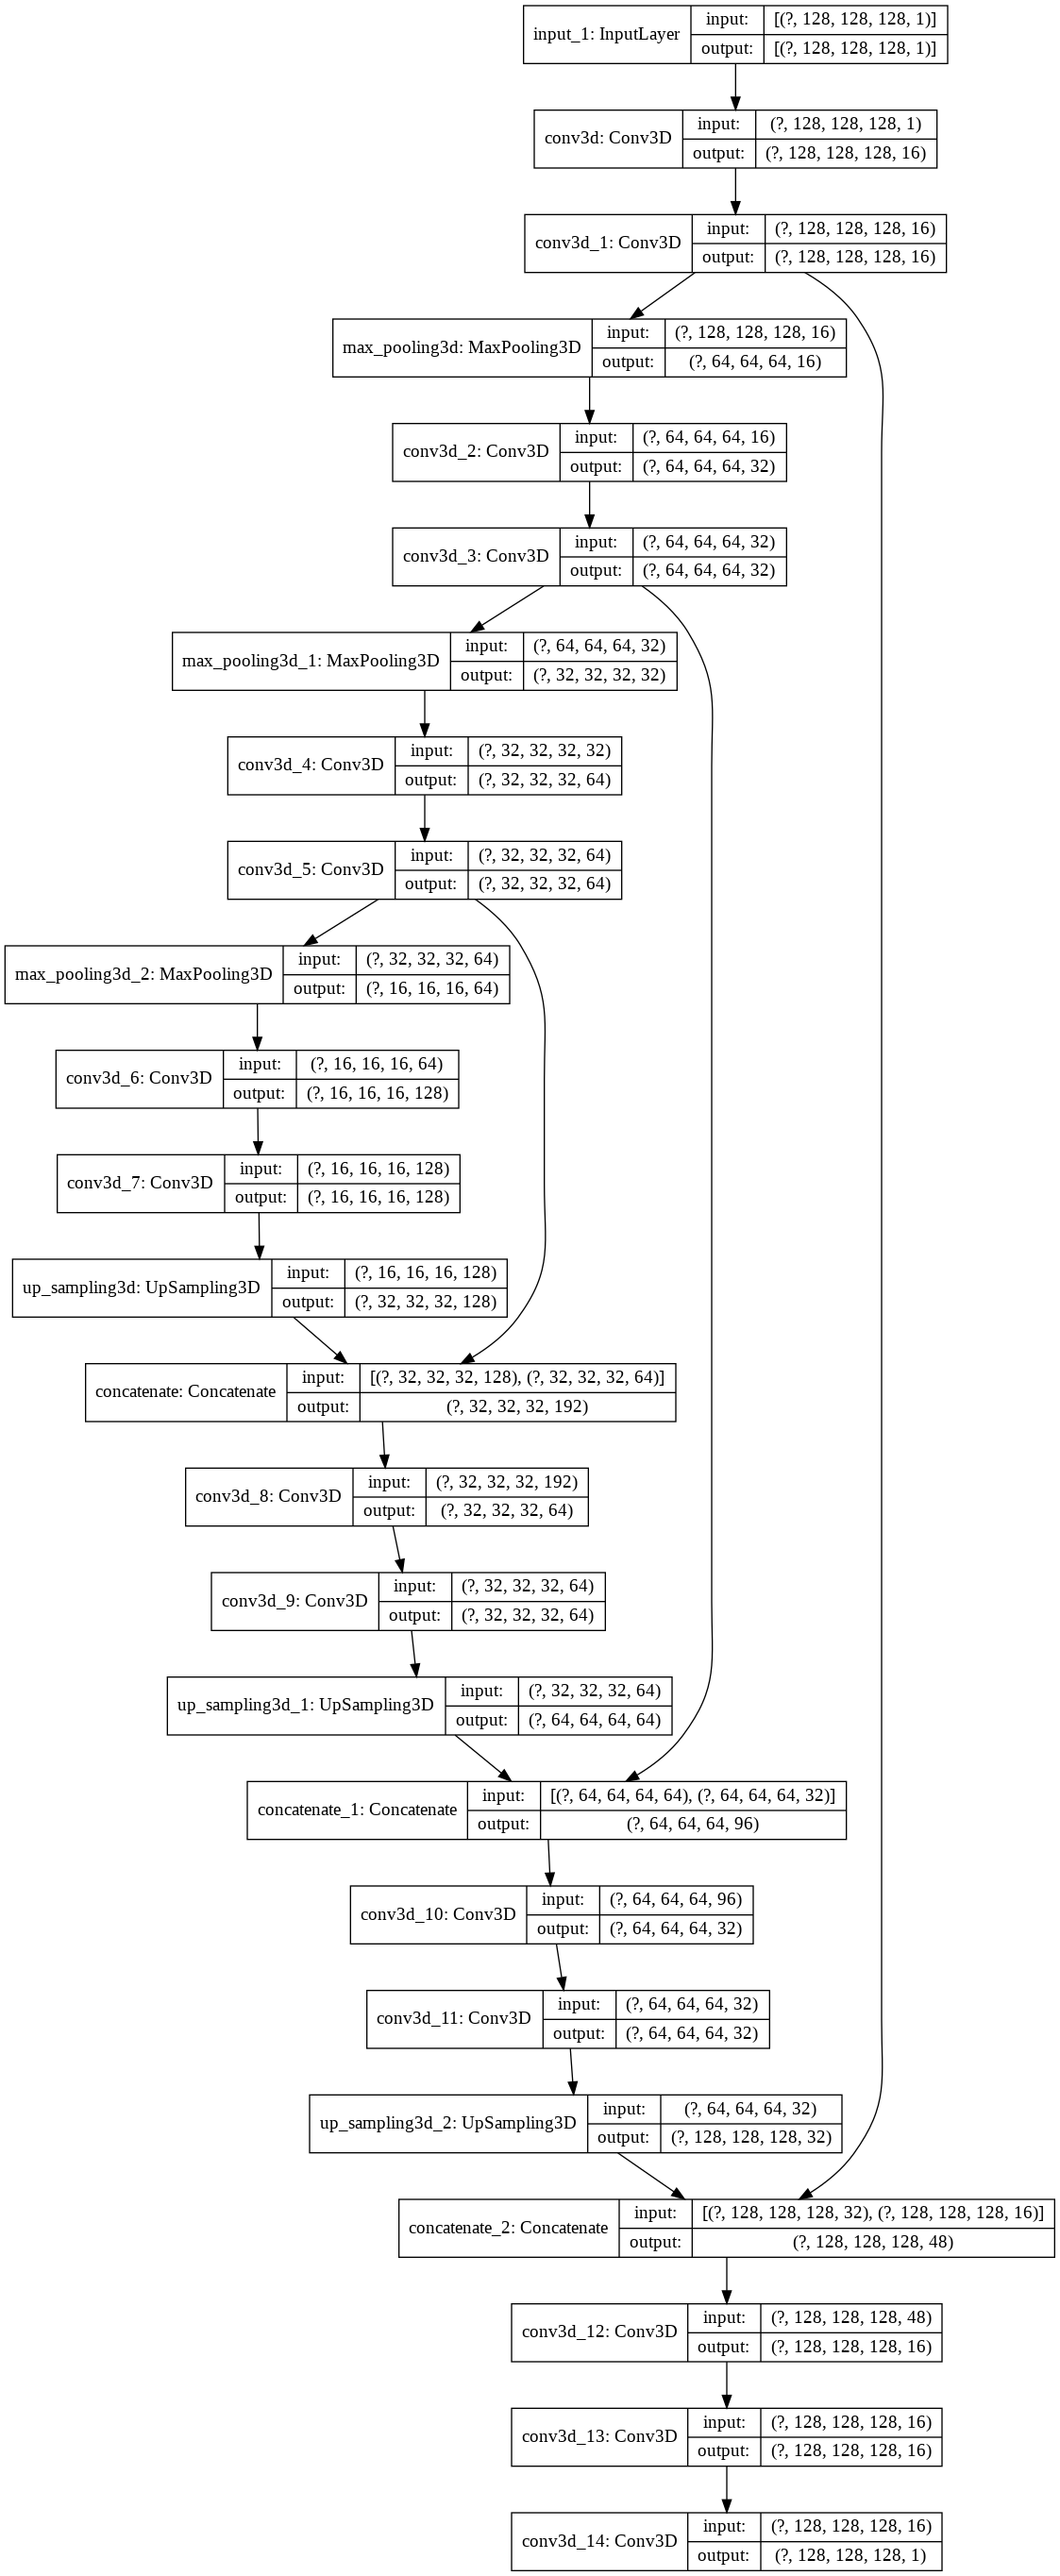

In [18]:
from deeplr.estimate import losses
from deeplr.estimate import metrics
 

def compile_convnet(input_size, lr):
    ''' Compile 3D ConvnNets '''
    # Downward
    inputs = Input(input_size)    
    conv1, pool1 = conv3d_down(inputs, 2**4, pooling=True)
    conv2, pool2 = conv3d_down(pool1, 2**5, pooling=True)
    conv3, pool3 = conv3d_down(pool2, 2**6, pooling=True)
    
    # Bottom
    conv4 = Conv3D_with_prm(pool3, 2**7)
    conv4 = Conv3D_with_prm(conv4, 2**7)

    # Upward
    conv5 = conv3d_up(conv4, conv3, 2**6)
    conv6 = conv3d_up(conv5, conv2, 2**5)
    conv7 = conv3d_up(conv6, conv1, 2**4)
    outputs = Conv3D(1, kernel_size=(1,1,1), activation='sigmoid')(conv7)

        
    recall = tf.metrics.Recall(name="recall")
    precision = tf.metrics.Precision(name="precision")



    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss=cross_entropy_balanced, metrics=['acc', metrics.dice_coef, recall, precision])
    return model


WB_CONFIG.lr = 0.001
WB_CONFIG.tv_gamma = 0.75
WB_CONFIG.tv_alpha = 0.7

model = compile_convnet(VOLUME_SHAPE + [1,], lr=WB_CONFIG.lr)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler



LOGS='./logs'
CHECKPOINT = '/content/drive/My Drive/Faults/3D_2DSynt_Segmentation/models/base_model_synt_date0810augs512_dilate.h5' # your path

# Save checkpoints
checkpoint = ModelCheckpoint(CHECKPOINT, monitor='val_loss', verbose=1, save_weights_only=False , save_best_only=True, mode='min')


WB_CONFIG.patience = 3
# Callbacks 
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=WB_CONFIG.patience, min_lr=0.000001, verbose=1)

def lr_sheduler(epoch, lrate):
	return lrate
    
lrs = LearningRateScheduler(lr_sheduler)


callbacks_list = [checkpoint, reduce_lr, WandbCallback()]

In [20]:
STEPS_PER_EPOCH = TRAINSET_SIZE // WB_CONFIG.BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // WB_CONFIG.BATCH_SIZE

WB_CONFIG.epochs = 100


model_history = model.fit(dataset['train'], epochs=WB_CONFIG.epochs,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['valid'],
                          callbacks=callbacks_list)

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 0.0644 - acc: 0.5459 - dice_coef: 0.1183 - recall: 0.7183 - precision: 0.0793
Epoch 00001: val_loss improved from inf to 0.04794, saving model to /content/drive/My Drive/Faults/3D_2DSynt_Segmentation/models/base_model_synt_date0810augs512_dilate.h5
119/119 [==============================] - 215s 2s/step - loss: 0.0644 - acc: 0.5459 - dice_coef: 0.1183 - recall: 0.7183 - precision: 0.0793 - val_loss: 0.0479 - val_acc: 0.7580 - val_dice_coef: 0.1763 - val_recall: 0.8333 - val_precision: 0.1615 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 0.0379 - acc: 0.8279 - dice_coef: 0.2637 - recall: 0.8446 - precision: 0.2133
Epoch 00002: val_loss improved from 0.04794 to 0.02435, saving model to /content/drive/My Drive/Faults/3D_2DSynt_Segmentation/models/base_model_synt_date0810augs512_dilate.h5
119/119 [==============================] - 204s 2s/step - loss: 0.0379 - acc: 0.8279 - dice_coe

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/My Drive/Faults/3D_2DSynt_Segmentation/models/base_model_synt_date0510.h5')

In [ ]:
model.save('/content/drive/My Drive/Faults/3D_2DSynt_Segmentation/models/base_model_synt_date0510.h5')

In [24]:
model = tf.keras.models.load_model(CHECKPOINT,
                                   custom_objects={'cross_entropy_balanced': cross_entropy_balanced})
model.summary()

ValueError: ignored

In [22]:
check_label = None

for (traces, labels) in dataset['test'].take(3): # train, pretrain
    for i, tr in enumerate(traces):
        lb = labels[i].numpy()[None, ...]
        tr = tr.numpy()[None, ...]

        pr_lb = model.predict(tr).squeeze()

        tr = tr.squeeze()

        for i, s in enumerate(pr_lb):
            m = s > 0.8
            s[m] = 1
            s[~m] = 0
            
            fig, axs = plt.subplots(1, 2, figsize=(10, 10))
            axs[0].imshow(tr[i].squeeze(), cmap='gray')
            axs[0].imshow(s, alpha=0.5)
            axs[1].imshow(tr[i].squeeze(), cmap='gray')

            if i == 7:
                break

            #break
        break

Output hidden; open in https://colab.research.google.com to view.

In [23]:
#@title slice viewer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets.widgets import *
from ipywidgets import widgets
from IPython.display import display

plt.style.use('seaborn-white')



class SliceViewer():

    '''
        Arguments: 
            traces_volume - np.array with shape (nx, ny, nz)
            labels_volume - np.array with shape (nx, ny, nz)
            figsize - tuple, plot size

    '''

    def __init__(self, traces_volume, labels_volume,
                 figsize=(7, 7), tr_cmap='gray', lb_cmap='Greens'):

        assert traces_volume.shape == labels_volume.shape, 'Shapes must be equal'

        self.tr_volume = traces_volume
        self.lb_volume = labels_volume
        self.figsize = figsize
        self.tr_cmap = tr_cmap
        self.lb_cmap = lb_cmap

        self.nx, self.ny, self.nz = self.tr_volume.shape

        self.widget = self.__create_widget()


    def __create_widget(self):

        x_slider = IntSlider(min=0, max=self.nx - 1, step=1, value=int(self.nx/2))
        y_slider = IntSlider(min=0, max=self.ny - 1, step=1, value=int(self.ny/2))
        z_slider = IntSlider(min=0, max=self.nz - 1, step=1, value=int(self.nz/2))
        alpha = IntSlider(min=0, max=100, step=5, value=70)
        selector = ['x','y','z']
        w = interact(self.__show, x=x_slider, y=y_slider,
                     z=z_slider, alpha=alpha, dim=selector)

        return w

    
    def __get_slice(self, x, y, z, dim):

        if dim == 'x':
            tr = self.tr_volume[x, :, :]
            lb = self.lb_volume[x, :, :]
        elif dim == 'y':
            tr = self.tr_volume[:, y, :]
            lb = self.lb_volume[:, y, :]
        else:
            tr = self.tr_volume[:, :, z]
            lb = self.lb_volume[:, :, z]
        
        return tr, lb


    def __set_labels(self, ax, dim):

        if dim == 'x':
            ax.set_xlabel('y')
            ax.set_ylabel('z')
        elif dim == 'y':
            ax.set_xlabel('x')
            ax.set_ylabel('z')
        else:
            ax.set_xlabel('y')
            ax.set_ylabel('x')

    
    def __show(self, x, y, z, alpha, dim):

        tr, lb = self.__get_slice(x, y, z, dim)

        fig, ax = plt.subplots(figsize=self.figsize)
        plt.imshow(tr.T, cmap=self.tr_cmap, aspect='equal')
        plt.imshow(lb.T, alpha=(100-alpha)/100, aspect='equal', cmap=self.lb_cmap)
        self.__set_labels(ax, dim)
        plt.grid()
        plt.show()
        display()

        ax.set_xlabel('x')
        ax.set_ylabel('z')


In [ ]:
SliceViewer(tr, pr_lb, figsize=(12, 12), tr_cmap='seismic', lb_cmap='seismic')

interactive(children=(IntSlider(value=64, description='x', max=127), IntSlider(value=64, description='y', max=…

# Test model

In [ ]:
!pip install segyio
!pip install obspy

     |████████████████████████████████| 92kB 5.6MB/s 
     |████████████████████████████████| 24.7MB 46.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for obspy: filename=obspy-1.2.2-cp36-cp36m-linux_x86_64.whl size=21666265 sha256=9541b27849791fe5bec3596b8180698d4592adab19e5083e990fbd28a0d2755d
  Stored in directory: /root/.cache/pip/wheels/94/e0/86/44fd4cea7661f42431c8f6d030f2758ff275cccffcbe8fa2b8
Successfully built obspy


In [ ]:
from obspy.io.segy.core import _read_segy as read_segy
from obspy.io.segy.segy import _read_segy
import numpy as np
image_sgy_stream = read_segy('/content/drive/My Drive/Faults/preprocess/sgyprocess/F3_entire.sgy')
image_sgy = np.stack(t.data for t in image_sgy_stream.traces)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
data_sgy = np.zeros((651 * 951, 462))
data_sgy.shape

(619101, 462)

In [ ]:
extend_count = data_sgy.shape[0] - image_sgy.shape[0]
extend_count

18586

In [ ]:
data_sgy[:image_sgy.shape[0], :] = image_sgy

In [ ]:
data_sgy = np.array(data_sgy).reshape(651, 951, 462)
data_sgy_reshaped = data_sgy
data_sgy.shape

(651, 951, 462)

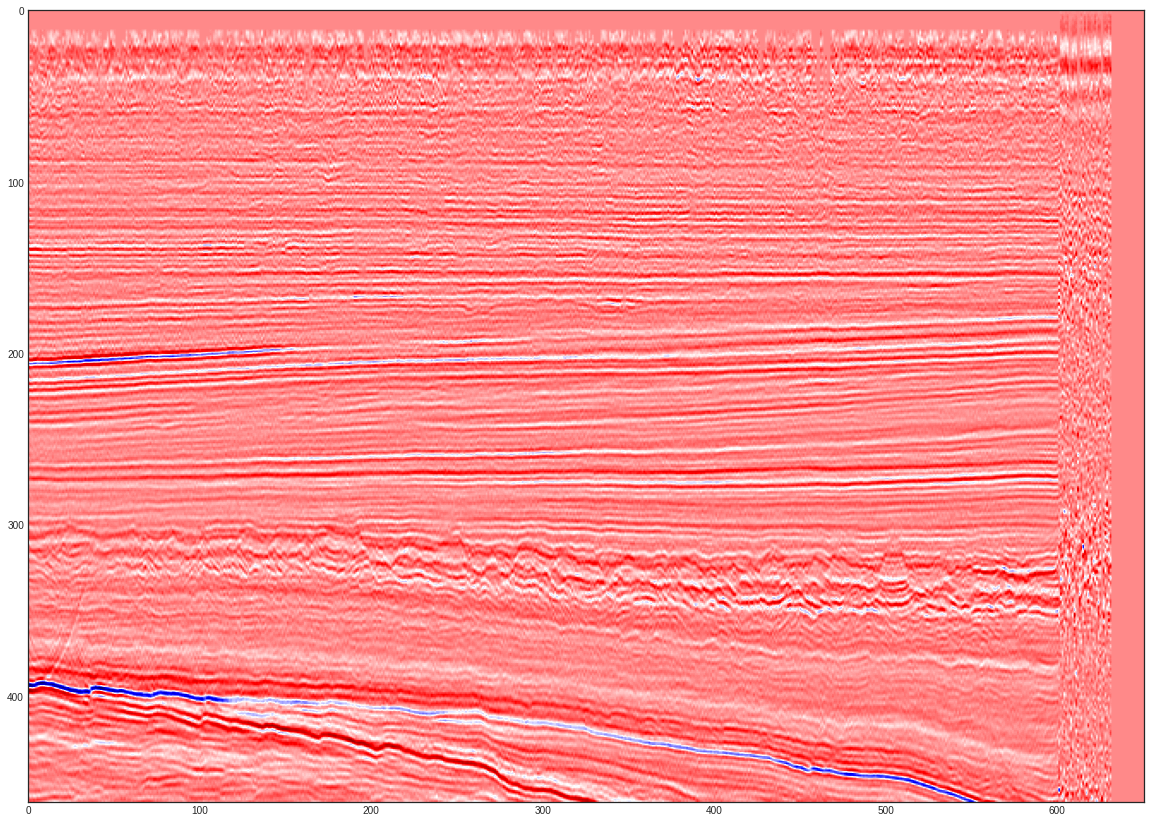

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.imshow(data_sgy[:, 20, :].T, cmap='seismic')

In [ ]:
#@title slice viewer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets.widgets import *
from ipywidgets import widgets
from IPython.display import display

plt.style.use('seaborn-white')



class SliceViewer():

    '''
        Arguments: 
            traces_volume - np.array with shape (nx, ny, nz)
            labels_volume - np.array with shape (nx, ny, nz)
            figsize - tuple, plot size

    '''

    def __init__(self, traces_volume, labels_volume,
                 figsize=(7, 7), tr_cmap='gray', lb_cmap='Greens'):

        assert traces_volume.shape == labels_volume.shape, 'Shapes must be equal'

        self.tr_volume = traces_volume
        self.lb_volume = labels_volume
        self.figsize = figsize
        self.tr_cmap = tr_cmap
        self.lb_cmap = lb_cmap

        self.nx, self.ny, self.nz = self.tr_volume.shape

        self.widget = self.__create_widget()


    def __create_widget(self):

        x_slider = IntSlider(min=0, max=self.nx - 1, step=1, value=int(self.nx/2))
        y_slider = IntSlider(min=0, max=self.ny - 1, step=1, value=int(self.ny/2))
        z_slider = IntSlider(min=0, max=self.nz - 1, step=1, value=int(self.nz/2))
        alpha = IntSlider(min=0, max=100, step=5, value=70)
        selector = ['x','y','z']
        w = interact(self.__show, x=x_slider, y=y_slider,
                     z=z_slider, alpha=alpha, dim=selector)

        return w

    
    def __get_slice(self, x, y, z, dim):

        if dim == 'x':
            tr = self.tr_volume[x, :, :]
            lb = self.lb_volume[x, :, :]
        elif dim == 'y':
            tr = self.tr_volume[:, y, :]
            lb = self.lb_volume[:, y, :]
        else:
            tr = self.tr_volume[:, :, z]
            lb = self.lb_volume[:, :, z]
        
        return tr, lb


    def __set_labels(self, ax, dim):

        if dim == 'x':
            ax.set_xlabel('y')
            ax.set_ylabel('z')
        elif dim == 'y':
            ax.set_xlabel('x')
            ax.set_ylabel('z')
        else:
            ax.set_xlabel('y')
            ax.set_ylabel('x')

    
    def __show(self, x, y, z, alpha, dim):

        tr, lb = self.__get_slice(x, y, z, dim)

        fig, ax = plt.subplots(figsize=self.figsize)
        plt.imshow(tr.T, cmap=self.tr_cmap, aspect='equal')
        plt.imshow(lb.T, alpha=(100-alpha)/100, aspect='equal', cmap=self.lb_cmap)
        self.__set_labels(ax, dim)
        plt.grid()
        plt.show()
        display()

        ax.set_xlabel('x')
        ax.set_ylabel('z')


In [ ]:
SliceViewer(data_sgy, data_sgy, figsize=(12, 12), tr_cmap='seismic', lb_cmap='seismic')

interactive(children=(IntSlider(value=325, description='x', max=650), IntSlider(value=475, description='y', ma…

In [ ]:
def scale_min_max(x):
    x = (x - x.min()) / (x.max() - x.min())
    return x


def standardise(trace):
    mean = trace.mean()
    std = trace.std()
    return (trace - mean) / std


start_i = 200

sub_volume = data_sgy[:128, start_i:start_i + 128 ,334:462]

# sub_volume = standardise(scale_min_max(sub_volume))

sub_volume = scale_min_max(sub_volume)

sub_volume.shape, sub_volume.min(), sub_volume.max()

((128, 128, 128), 0.0, 1.0)

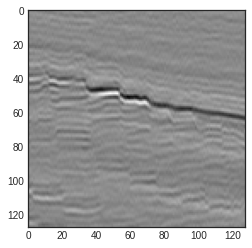

In [ ]:
plt.imshow(sub_volume[50].T, cmap='gray')

In [ ]:
pr = model.predict(sub_volume[None, ..., None])
pr = pr.squeeze()
pr.shape

(128, 128, 128)

In [ ]:
#@title slice viewer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets.widgets import *
from ipywidgets import widgets
from IPython.display import display

plt.style.use('seaborn-white')



class SliceViewer():

    '''
        Arguments: 
            traces_volume - np.array with shape (nx, ny, nz)
            labels_volume - np.array with shape (nx, ny, nz)
            figsize - tuple, plot size

    '''

    def __init__(self, traces_volume, labels_volume,
                 figsize=(7, 7), tr_cmap='gray', lb_cmap='Greens'):

        assert traces_volume.shape == labels_volume.shape, 'Shapes must be equal'

        self.tr_volume = traces_volume
        self.lb_volume = labels_volume
        self.figsize = figsize
        self.tr_cmap = tr_cmap
        self.lb_cmap = lb_cmap

        self.nx, self.ny, self.nz = self.tr_volume.shape

        self.widget = self.__create_widget()


    def __create_widget(self):

        x_slider = IntSlider(min=0, max=self.nx - 1, step=1, value=int(self.nx/2))
        y_slider = IntSlider(min=0, max=self.ny - 1, step=1, value=int(self.ny/2))
        z_slider = IntSlider(min=0, max=self.nz - 1, step=1, value=int(self.nz/2))
        alpha = IntSlider(min=0, max=100, step=5, value=70)
        selector = ['x','y','z']
        w = interact(self.__show, x=x_slider, y=y_slider,
                     z=z_slider, alpha=alpha, dim=selector)

        return w

    
    def __get_slice(self, x, y, z, dim):

        if dim == 'x':
            tr = self.tr_volume[x, :, :]
            lb = self.lb_volume[x, :, :]
        elif dim == 'y':
            tr = self.tr_volume[:, y, :]
            lb = self.lb_volume[:, y, :]
        else:
            tr = self.tr_volume[:, :, z]
            lb = self.lb_volume[:, :, z]
        
        return tr, lb


    def __set_labels(self, ax, dim):

        if dim == 'x':
            ax.set_xlabel('y')
            ax.set_ylabel('z')
        elif dim == 'y':
            ax.set_xlabel('x')
            ax.set_ylabel('z')
        else:
            ax.set_xlabel('y')
            ax.set_ylabel('x')

    
    def __show(self, x, y, z, alpha, dim):

        tr, lb = self.__get_slice(x, y, z, dim)

        fig, ax = plt.subplots(figsize=self.figsize)
        plt.imshow(tr.T, cmap=self.tr_cmap, aspect='equal')
        plt.imshow(lb.T, alpha=(100-alpha)/100, aspect='equal', cmap=self.lb_cmap)
        self.__set_labels(ax, dim)
        plt.grid()
        plt.show()
        display()

        ax.set_xlabel('x')
        ax.set_ylabel('z')


In [ ]:
m = pr > 0.8
pr[m] = 1
pr[~m] = 0

In [ ]:
SliceViewer(sub_volume, pr, figsize=(7, 7))

interactive(children=(IntSlider(value=64, description='x', max=127), IntSlider(value=64, description='y', max=…

In [ ]:
for i in range(128):

    fig, axs = plt.subplots(1, 2, figsize=(10, 10))

    s = sub_volume[i].T
    lb = pr[i].T
    m = lb > 0.5
    lb[m] = 1
    lb[~m] = 0

    axs[0].imshow(s, cmap='gray')
    axs[0].imshow(lb, alpha=0.5)
    axs[1].imshow(s, cmap='gray')

    if i == 20:
        break

Output hidden; open in https://colab.research.google.com to view.